### <span style="color:red"> HALO-ORBIT AROUND EARTH-MOON LAGRANGIAN POINTS (L1, L2, L3)</span>

Lagrange points are the points of equilibrium in the gravitational interaction between two large objects (in this case the Earth and the Moon), but they are not stable points. In other words, an object that is perfectly at rest at the Lagrange point can be shaken out of equilibrium.
However, halo orbits rotate around the Lagrange points. Halo orbits are regions of validity around the equilibrium points, ensuring that the object has a stable orbit.  
The reason why halo orbits are valid is as follows:  
1.) Halo orbits around the Lagrange point oscillate due to gravity and other interactions, but they are orbits that rotate with a certain period. The halo orbit continues in a certain orbit by balancing the effects that disturb the orbit. This provides a kind of **dynamic balance**.  
2.) Halo orbits exhibit a periodic motion, and devices such as spacecraft or telescopes exhibit a certain continuous motion while rotating in this orbit. In this way, an object placed exactly on the Lagrange point rotates in the halo orbit, compensating for the instability.

Halo orbits offer great advantages for performing long-term and stable missions in space. They allow a satellite or spacecraft to monitor the same area for long periods of time, independent of gravitational effects.
In addition, halo orbits around Lagrange points provide low fuel consumption for long-term missions. Orbital dynamics allow the spacecraft to continuously adjust its speed and direction. In this way, long-term missions can be performed without providing constant thrust.

<img src="image_CRTBP_Earth-Moon.png" width="600">

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint


In [256]:
# Parameters
mu = 0.012150581623433
ToL = 1e-6
err = 1
Nmax = 50
x0_L2 = 1

In [ ]:
def fx(x):
    return x - ((1 - mu) * (x + mu)) / abs(x + mu)**3 - mu * (x + mu - 1) / abs(x + mu - 1)**3

In [213]:
xL2 = fsolve(fx, x0_L2)[0]

In [214]:
def ycross(t, x, mu):
    return x[1]  # y = 0'ı geçtiğinde durdurur

ycross.terminal = True
ycross.direction = 0

# ODE çözücü fonksiyonu
def propagate(x0, tspan, mu, stop=False):
    if stop:
        events = lambda t, x: ycross(t, x, mu)
        sol = solve_ivp(lambda t, x: CRTBP_STM(t, x, mu), [0, tspan], x0, method='RK45',
                        rtol=1e-12, atol=1e-12, events=events)
    else:
        sol = solve_ivp(lambda t, x: CRTBP_STM(t, x, mu), [0, tspan], x0, method='RK45',
                        rtol=1e-12, atol=1e-12)
    
    t = sol.t
    rv = sol.y[:6, :].T
    PHI_a = sol.y[6:, -1].reshape((6, 6)) if stop else None
    return t, rv, PHI_a

The given as a 6-dimensional vector, each corresponding to the position and velocity components, respectively.

$$ \mathbf{r_0} = \left[ x_0, y_0, z_0, \dot{x_0}, \dot{y_0}, \dot{z_0} \right] = \left[ 1.0892891445324, 0, 0.0591799623455459, 0, 0, 0 \right] $$


In [215]:
# Initial Points
rv0 = np.array([1.08892819445324, 0, 0.0591799623455459, 0, 0.257888699435051, 0])
PHI0 = np.eye(6) # 6x6 identity matrix
x0 = np.concatenate((rv0, PHI0.flatten()))
print (x0)

[1.08892819 0.         0.05917996 0.         0.2578887  0.
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.        ]


In [207]:
def CRTBP_STM(t, x, mu):
    rr = x[0:3]
    vv = x[3:6]
    PHI = x[6:].reshape((6, 6))
    
    rr1 = rr - np.array([-mu, 0, 0])
    r1 = np.linalg.norm(rr1)
    rr2 = rr - np.array([1 - mu, 0, 0])
    r2 = np.linalg.norm(rr2)
    
    rvdot = np.array([
        vv[0],
        vv[1],
        vv[2],
        2 * vv[1] + rr[0] - ((1 - mu) * (rr[0] + mu) / r1**3 + mu * (rr[0] + mu - 1) / r2**3),
        -2 * vv[0] + rr[1] - ((1 - mu) / r1**3 + mu / r2**3) * rr[1],
        -((1 - mu) / r1**3 + mu / r2**3) * rr[2]
    ])
    
    A = compute_A_matrix(rr, r1, r2, mu)
    PHI_dot = A @ PHI
    xdot = np.concatenate((rvdot, PHI_dot.flatten()))
    return xdot

# A matrisini hesaplayan fonksiyon
def compute_A_matrix(rr, r1, r2, mu):
    U_xx = 1 - (1 - mu) / r1**3 - mu / r2**3 + 3 * (1 - mu) * (rr[0] + mu)**2 / r1**5 + 3 * mu * (rr[0] + mu - 1)**2 / r2**5
    U_xy = 3 * (1 - mu) * (rr[0] + mu) * rr[1] / r1**5 + 3 * mu * (rr[0] + mu - 1) * rr[1] / r2**5
    U_yy = 1 - (1 - mu) / r1**3 - mu / r2**3 + 3 * (1 - mu) * rr[1]**2 / r1**5 + 3 * mu * rr[1]**2 / r2**5
    U_zz = -(1 - mu) / r1**3 - mu / r2**3 + 3 * (1 - mu) * rr[2]**2 / r1**5 + 3 * mu * rr[2]**2 / r2**5
    
    A = np.array([
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [U_xx, U_xy, 0, 0, 2, 0],
        [U_xy, U_yy, 0, -2, 0, 0],
        [0, 0, U_zz, 0, 0, 0]
    ])
    return A


In [316]:
while abs(err) > ToL and k < Nmax:
    k += 1
    stop = 1  # To stop the simulation when it passes y = 0

    # Propagation and error calculation
    tt, rv, PHI_a = propagate(x0, 2 * np.pi, mu, stop)
    rvf = rv[-1, :]
    err = abs(rvf[3]) + abs(rvf[5])
    PHI = PHI_a  # STM is analytical

    # Deviation of desired flow from the reference flow @ tf
    dvxf = -rvf[3]
    dvzf = -rvf[5]
    # Deviation of desired flow from the reference flow @ t0
    dvy0 = (PHI[3, 2] * dvzf - PHI[5, 2] * dvxf) / (PHI[5, 4] * PHI[3, 2] - PHI[5, 2] * PHI[3, 4])
    dz0 = (-PHI[3, 4] * dvzf + PHI[5, 4] * dvxf) / (PHI[5, 4] * PHI[3, 2] - PHI[5, 2] * PHI[3, 4])

    stop = 1
    ttf, rvf, PHI_af = propagate(x0, 2 * np.pi, mu, stop)
    ttb, rvb, PHI_ab = propagate(x0, -2 * np.pi, mu, stop)
    
    x0_conv = x0  # Update convergent x0

    # Apply the differential correction
    x0[2] += dz0
    x0[4] += dvy0



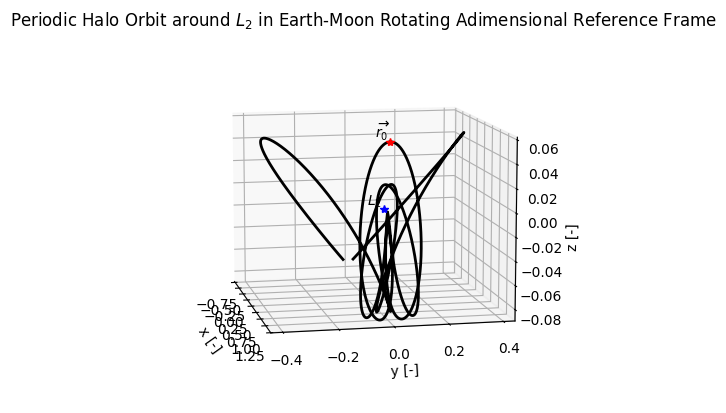

In [317]:
# Plotting the periodic halo orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
stop = 1

ax.plot(rvf[:, 0], rvf[:, 1], rvf[:, 2], color='k', linewidth=2)
ax.plot(rvb[:, 0], rvb[:, 1], rvb[:, 2], color='k', linewidth=2)

ax.plot(rvf[0, 0], rvf[0, 1], rvf[0, 2], '*', color='r', linewidth=2)
ax.text(rvf[0, 0], rvf[0, 1], rvf[0, 2], '$\\overrightarrow{r_0}$', verticalalignment='bottom', horizontalalignment='right')
ax.plot([xL2], [0], [0], '*', color='b', linewidth=2)
ax.text( xL2, 0, 0, '$L_2$ ', verticalalignment='bottom', horizontalalignment='right')

ax.grid(True)
ax.set_xlabel('x [-]')
ax.set_ylabel('y [-]')
ax.set_zlabel('z [-]')
plt.title('Periodic Halo Orbit around $L_2$ in Earth-Moon Rotating Adimensional Reference Frame')

ax.view_init(elev=10, azim=-12)